# ESDA

Exploratory Spatial Data Analysis using PySal

Useful links: 

- http://pysal.org/notebooks/viz/splot/esda_morans_viz.html

- https://towardsdatascience.com/what-is-exploratory-spatial-data-analysis-esda-335da79026ee

- http://ljwolf.org/post/spatial_acf/

- Original LISA article: https://dces.webhosting.cals.wisc.edu/wp-content/uploads/sites/128/2013/08/W4_Anselin1995.pdf

Import libraries

In [36]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local,Moran_BV,Moran_Local_BV
from splot.esda import moran_scatterplot,plot_local_autocorrelation,lisa_cluster,plot_moran_bv
import geopandas as gpd
sys.path.append(os.path.abspath('..'))
%matplotlib inline

Loading shp file for cities in Brazil

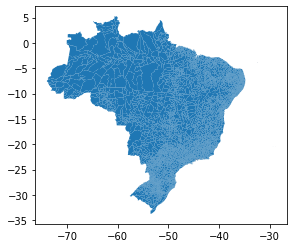

In [2]:
gdf = gpd.read_file('municipios/BRMUE250GC_SIR.shp')
gdf.plot()

## Spatial autocorrelation
Spatial autocorrelation describes the presence or absence of spacial variations in a given variable.

- Positive spatial autocorrelation: areas close to each other have similar values (High-high or Low-low)
- Negative spatial autocorrelation: neighbourhood areas are different from each other (Low-high or High-low) 

There are two types of spatial autocorrelation:

- Global: focuses on the overall trend in the dataset and gives us information about the degree of clustering 
- Local: detects variability and divergence in the dataset

Calculating contiguity weights (spacial similarity) with Queen.from_dataframe

"Spatial similarity relation refers to similarity among and between objects on maps or in geographic space"
(source: https://www.sciencedirect.com/science/article/pii/S1674984715000191)

Spatial weights are how we determine the area’s neighborhood

In [3]:
w = Queen.from_dataframe(gdf)
w.transform = 'r'

('WARNING: ', 3321, ' is an island (no neighbors)')
('WARNING: ', 4008, ' is an island (no neighbors)')


C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3321, 4008.
  warnings.warn(message)


Taking a look at gdf 

In [6]:
gdf

,NM_MUNICIP,CD_GEOCMU,geometry
0,CACHOEIRA DO PIRIÁ,1501956,"POLYGON ((-46.31955 -1.75518, -46.31990 -1.755..."
1,SÃO JOSÉ DOS BASÍLIOS,2111250,"POLYGON ((-44.63409 -5.03498, -44.63407 -5.034..."
2,APARECIDA DO RIO DOCE,5201454,"POLYGON ((-51.14230 -18.29672, -51.14236 -18.2..."
3,ARENÓPOLIS,5202353,"POLYGON ((-51.69953 -16.23270, -51.69957 -16.2..."
4,CURUÁ,1502855,"POLYGON ((-55.17193 -1.83331, -55.16647 -1.731..."
...,...,...,...
5567,PARAGUAÇU PAULISTA,3535507,"POLYGON ((-50.69420 -22.39885, -50.69410 -22.3..."
5568,ÁGUA LIMPA,5200209,"POLYGON ((-48.86197 -17.98972, -48.86111 -17.9..."
5569,SANTA CRUZ DO SUL,4316808,"POLYGON ((-52.46848 -29.70647, -52.46847 -29.7..."
5570,SAUDADES,4217303,"POLYGON ((-53.10221 -26.93414, -53.10236 -26.9..."


CD_GEOCMU is the 7-digit city code, we need to convert it to the standard 6-digit code

In [8]:
cadmun = pd.read_csv('../util/CADMUN.csv')
cadmun = cadmun[["MUNCOD", "MUNCODDV"]]
gdf["CD_GEOCMU"] = gdf["CD_GEOCMU"].astype(int)
gdf_city = pd.merge(gdf, cadmun,  left_on="CD_GEOCMU", right_on="MUNCODDV", how="left")

,NM_MUNICIP,CD_GEOCMU,geometry,MUNCOD,MUNCODDV
0,CACHOEIRA DO PIRIÁ,1501956,"POLYGON ((-46.31955 -1.75518, -46.31990 -1.755...",150195.0,1501956.0
1,SÃO JOSÉ DOS BASÍLIOS,2111250,"POLYGON ((-44.63409 -5.03498, -44.63407 -5.034...",211125.0,2111250.0
2,APARECIDA DO RIO DOCE,5201454,"POLYGON ((-51.14230 -18.29672, -51.14236 -18.2...",520145.0,5201454.0
3,ARENÓPOLIS,5202353,"POLYGON ((-51.69953 -16.23270, -51.69957 -16.2...",520235.0,5202353.0
4,CURUÁ,1502855,"POLYGON ((-55.17193 -1.83331, -55.16647 -1.731...",150285.0,1502855.0
...,...,...,...,...,...
5567,PARAGUAÇU PAULISTA,3535507,"POLYGON ((-50.69420 -22.39885, -50.69410 -22.3...",353550.0,3535507.0
5568,ÁGUA LIMPA,5200209,"POLYGON ((-48.86197 -17.98972, -48.86111 -17.9...",520020.0,5200209.0
5569,SANTA CRUZ DO SUL,4316808,"POLYGON ((-52.46848 -29.70647, -52.46847 -29.7...",431680.0,4316808.0
5570,SAUDADES,4217303,"POLYGON ((-53.10221 -26.93414, -53.10236 -26.9...",421730.0,4217303.0


Merging with suicide CSV to get SUICIDE_RATE for each city

In [10]:
suicide = pd.read_csv('../Suicide/CSV/suicide_rate_codmunres.csv', sep=',')
result = pd.merge(gdf_city, suicide, left_on="MUNCOD", right_on="CODMUNRES", how="left")
result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "SUICIDE_RATE"]]
result['SUICIDE_RATE'] = result['SUICIDE_RATE'].fillna(0) #filling null values with 0

Defining the y dimension

In [11]:
y = result['SUICIDE_RATE'].values
y.shape


(5572,)

### Global spatial autocorrelation

Calculating Moran's I (measure of global spatial autocorrelation)

In [12]:
from esda.moran import Moran

moran = Moran(y, w)
moran.I

0.10596639670162877

We conclude that there is a positive spatial autocorrelation in this dataset.

Visualizing the global spatial autocorrelation

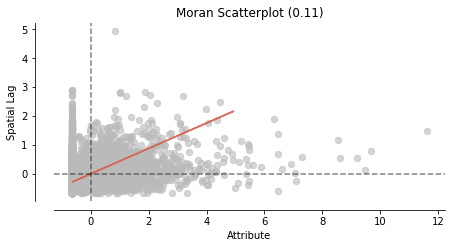

In [14]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

### Local spatial autocorrelation

Calculating Moran Local

In [15]:
moran_loc = Moran_Local(y, w)

C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\esda\moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


Plotting Moran's Local Scatter Plot

The scatter plot divides the areas into the four groups:
- High-high: top right
- High-low: bottom right
- Low-low: bottom left
- Low-high: top left


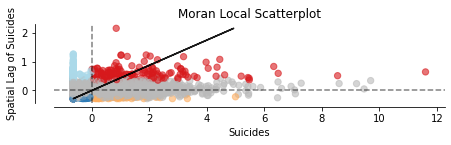

In [17]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial Lag of Suicides')
plt.show()

Visualizing the clusters on a map

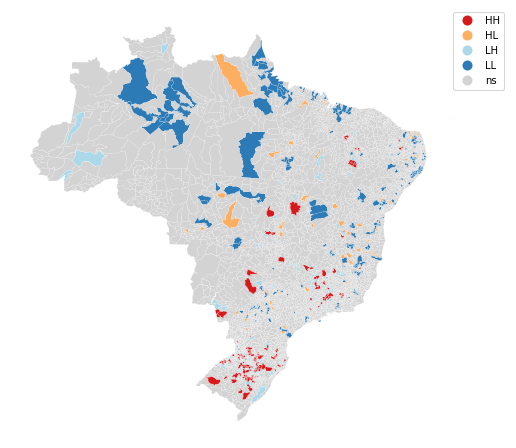

In [18]:
lisa_cluster(moran_loc, result, p=0.05, figsize = (9,9))
plt.show()

Combined visualizations 

C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


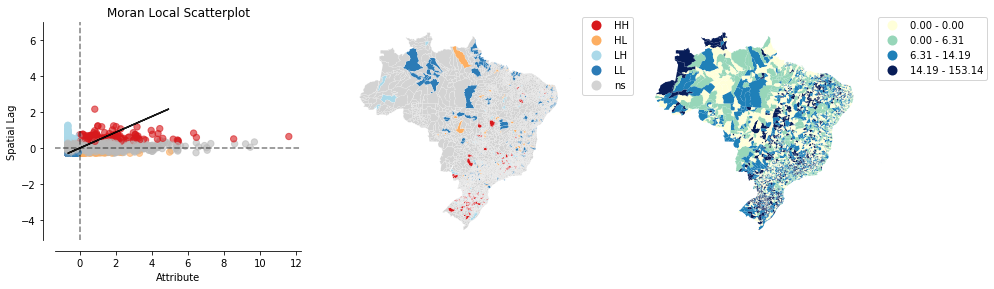

In [19]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, result, 'SUICIDE_RATE')
plt.show()

Choropleth map of suicide rates in Brazil (2017)

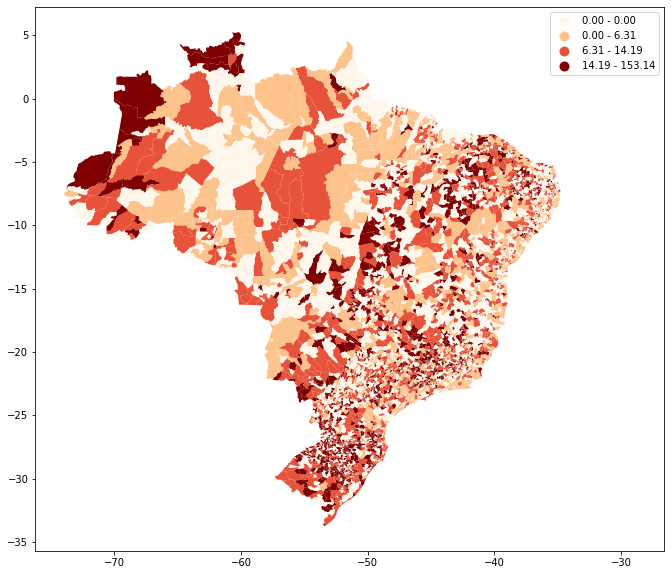

In [202]:
fig = result.plot(column='SUICIDE_RATE', legend=True, figsize=(15, 10),cmap='OrRd', scheme='quantiles')
plt.show()

C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


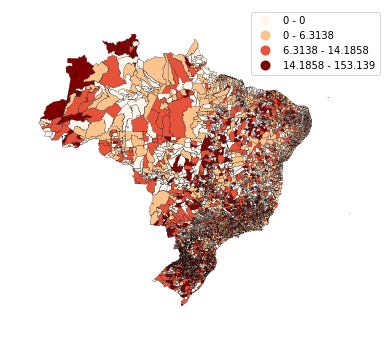

In [201]:
import geoplot as gplt
gplt.choropleth(result, hue='SUICIDE_RATE', cmap='OrRd',linewidth=0.2, scheme='quantiles',
                legend=True)

## Bivariate Moran Statistics

Inspecting the relationship of two variables and their position in space 

Loading disease data and merging with gdf

In [20]:
cancer = pd.read_csv('CANCERBR2017_RATE.csv', sep=',')
result = pd.merge(gdf_city, cancer, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "SUICIDE_RATE", "QUANTIDADE_RATE"]]
result['SUICIDE_RATE'] = result['SUICIDE_RATE'].fillna(0)
result['QUANTIDADE_RATE'] = result['QUANTIDADE_RATE'].fillna(0)

Bivariate Moran Statistics describe the correlation between one variable and the spatial lag of another variable
 
IMPORTANT: Bivariate Moran Statistics do not take the inherent correlation between the two variables at the same location into account.

In [29]:
x = result['SUICIDE_RATE'].values
y = result['QUANTIDADE_RATE'].values

Calculating Moran's BV I

A single statistic (and accompanying (p)-values computed using permutation methods) that relates the values of attribute (x) to the lag of (y).

In [34]:
moran_bv = Moran_BV(y, x, w)
moran_bv.I

0.08815993594220561

Plotting Moran BV

In [ ]:
plot_moran_bv(moran_bv)
plt.show()

Calculating BV Moran Local

C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\esda\moran.py:1121: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


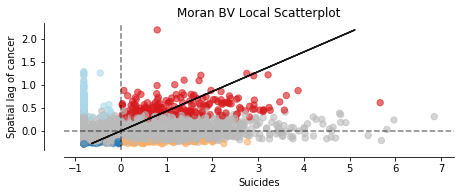

In [42]:
moran_loc_bv = Moran_Local_BV(y, x, w)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial lag of cancer')
plt.show()

C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\pypas\Anaconda3\envs\testJupyter\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


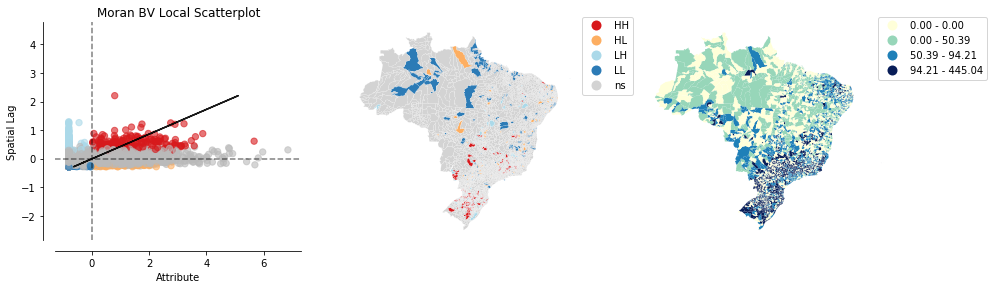

In [43]:
plot_local_autocorrelation(moran_loc_bv, result, 'QUANTIDADE_RATE')
plt.show()